# Differentiable Particle Filter — Soft & OT Resampling

**Implementation following:**
- [Corenflos et al., 2021] *Differentiable Particle Filtering via Entropy-Regularized Optimal Transport*, ICML.
- [Chen & Li, 2023] *An overview of differentiable particle filters for data-adaptive sequential Bayesian inference*, arXiv:2302.09639.

**Reference codebase:** [github.com/JTT94/filterflow](https://github.com/JTT94/filterflow)


## Cell 1 — Install & Imports

Colab ships with TensorFlow pre-installed. We just ensure `tensorflow-probability` is available.

In [1]:
# Colab already has TF; install TFP if needed
!pip install -q tensorflow-probability

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import time

tfd = tfp.distributions

print(f"TensorFlow  : {tf.__version__}")
print(f"TF-Probability: {tfp.__version__}")
print(f"GPU available : {tf.config.list_physical_devices('GPU')}")

TensorFlow  : 2.19.0
TF-Probability: 0.25.0
GPU available : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Cell 2 — Utility Functions

In [2]:
def normalize_log_weights(log_w):
    """Numerically stable normalisation of log-weights.

    Args:
        log_w: [B, N] unnormalised log-weights.
    Returns:
        log_w_norm: [B, N] normalised log-weights.
        log_evidence: [B] log of the normalising constant.
    """
    log_sum = tf.math.reduce_logsumexp(log_w, axis=-1, keepdims=True)
    log_w_norm = log_w - log_sum
    log_evidence = tf.squeeze(log_sum, axis=-1)
    return log_w_norm, log_evidence


def effective_sample_size(log_w_norm):
    """ESS = 1 / sum(w_i^2)  from normalised log-weights."""
    return tf.exp(-tf.math.reduce_logsumexp(2.0 * log_w_norm, axis=-1))


# Quick sanity check
_lw = tf.constant([[-1.0, -1.0, -1.0, -1.0]])  # uniform
_lw_n, _le = normalize_log_weights(_lw)
print("Normalised log-w:", _lw_n.numpy())
print("ESS (should be 4):", effective_sample_size(_lw_n).numpy())

Normalised log-w: [[-1.3862944 -1.3862944 -1.3862944 -1.3862944]]
ESS (should be 4): [4.]


## Cell 3 — Soft Resampler

Mix the normalised weights with a uniform distribution:

$$\tilde{w}^i = \alpha\, w^i + (1-\alpha)\,\frac{1}{N}$$

Sample ancestor indices from $\text{Categorical}(\tilde{w})$, then use the **straight-through estimator** to pass gradients through the discrete selection.

In [3]:
class SoftResampler:
    """Soft resampling via mixture with uniform.

    Forward pass:  sample ancestors from Categorical(w_soft).
    Backward pass: straight-through estimator using the soft weighted mean.
    Weight correction: log w_new^i = log w^{a_i} - log w_soft^{a_i}.
    """

    def __init__(self, alpha=0.5):
        """
        Args:
            alpha: mixing coefficient in (0, 1].
                1.0 = standard categorical (non-differentiable).
                0.0 = pure uniform (no weight info).  Typical: 0.5.
        """
        assert 0.0 < alpha <= 1.0
        self.alpha = alpha

    def __call__(self, particles, log_w_norm):
        """
        Args:
            particles:  [B, N, D]
            log_w_norm: [B, N] normalised log-weights.
        Returns:
            resampled_particles: [B, N, D]
            new_log_w:           [B, N]
        """
        B = tf.shape(particles)[0]
        N = tf.shape(particles)[1]
        Nf = tf.cast(N, tf.float32)

        w_norm = tf.exp(log_w_norm)                       # [B, N]
        w_uniform = tf.ones_like(w_norm) / Nf              # [B, N]
        w_soft = self.alpha * w_norm + (1.0 - self.alpha) * w_uniform

        # --- Sample ancestor indices (forward, non-differentiable) ---
        log_w_soft = tf.math.log(w_soft + 1e-30)
        dist = tfd.Categorical(logits=log_w_soft)          # batch [B]
        ancestors = dist.sample(N)                         # [N, B]
        ancestors = tf.transpose(ancestors)                # [B, N]

        # Gather resampled particles
        batch_idx = tf.broadcast_to(tf.range(B)[:, None], [B, N])
        gather_idx = tf.stack([batch_idx, ancestors], axis=-1)
        resampled_hard = tf.gather_nd(particles, gather_idx)  # [B, N, D]

        # --- Differentiable path: weighted mean (same for all i) ---
        x_interp = tf.reduce_sum(
            w_soft[:, :, None] * particles, axis=1, keepdims=True
        )  # [B, 1, D]
        x_interp = tf.broadcast_to(x_interp, tf.shape(particles))  # [B, N, D]

        # Straight-through estimator
        resampled = tf.stop_gradient(resampled_hard - x_interp) + x_interp

        # --- Weight correction ---
        log_w_ancestors = tf.gather_nd(log_w_norm, gather_idx)
        log_w_soft_ancestors = tf.math.log(
            tf.gather_nd(w_soft, gather_idx) + 1e-30
        )
        new_log_w = log_w_ancestors - log_w_soft_ancestors
        new_log_w = new_log_w - tf.math.reduce_logsumexp(
            new_log_w, axis=-1, keepdims=True
        )

        return resampled, new_log_w


print("SoftResampler defined.")

SoftResampler defined.


## Cell 4 — Sinkhorn (OT) Resampler

Find the entropy-regularised optimal transport plan $T$ that maps the weighted measure $\sum_i w_i \delta_{x_i}$ to the uniform measure $\frac{1}{N}\sum_i \delta_{x_i}$:

$$\min_{T \ge 0}\; \langle C, T\rangle + \varepsilon\,\text{KL}(T \| a\otimes b)$$

Solved via Sinkhorn iterations (all differentiable). Resampled particles:

$$x^{\text{new}}_i = N \sum_j T_{ji}\, x_j$$

In [4]:
class SinkhornResampler:
    """Differentiable resampling via entropy-regularised optimal transport."""

    def __init__(self, epsilon=0.5, num_iters=50):
        """
        Args:
            epsilon: entropic regularisation (0.1--1.0 typical).
            num_iters: max Sinkhorn iterations.
        """
        self.epsilon = epsilon
        self.num_iters = num_iters

    def _cost_matrix(self, particles):
        """Squared-Euclidean cost.  [B,N,D] -> [B,N,N]"""
        diff = particles[:, :, None, :] - particles[:, None, :, :]
        return tf.reduce_sum(diff ** 2, axis=-1)

    def _sinkhorn(self, C, log_a):
        """Sinkhorn in log-space.

        Args:
            C:     [B, N, N] cost matrix.
            log_a: [B, N]    source log-marginal (normalised weights).
        Returns:
            T: [B, N, N] transport plan.
        """
        N = tf.shape(C)[1]
        Nf = tf.cast(N, tf.float32)
        log_b = -tf.math.log(Nf) * tf.ones_like(log_a)   # uniform target
        log_K = -C / self.epsilon                          # Gibbs kernel

        log_u = tf.zeros_like(log_a)
        log_v = tf.zeros_like(log_b)

        for _ in range(self.num_iters):
            # u_i = a_i / sum_j K_{ij} v_j
            log_u = log_a - tf.math.reduce_logsumexp(
                log_K + log_v[:, None, :], axis=-1)
            # v_j = b_j / sum_i K_{ij} u_i
            log_v = log_b - tf.math.reduce_logsumexp(
                log_K + log_u[:, :, None], axis=1)

        log_T = log_u[:, :, None] + log_K + log_v[:, None, :]
        return tf.exp(log_T)

    def __call__(self, particles, log_w_norm):
        """
        Args:
            particles:  [B, N, D]
            log_w_norm: [B, N]
        Returns:
            resampled_particles: [B, N, D]
            new_log_w:           [B, N] (uniform after OT).
        """
        N = tf.shape(particles)[1]
        Nf = tf.cast(N, tf.float32)

        C = self._cost_matrix(particles)
        T = self._sinkhorn(C, log_w_norm)               # [B, N, N]

        # x_new_i = N * sum_j T_{ji} x_j
        transform = Nf * tf.transpose(T, perm=[0, 2, 1])  # [B, N, N]
        resampled = tf.matmul(transform, particles)        # [B, N, D]

        new_log_w = -tf.math.log(Nf) * tf.ones(
            [tf.shape(particles)[0], N], dtype=tf.float32)
        return resampled, new_log_w


print("SinkhornResampler defined.")

SinkhornResampler defined.


## Cell 5 — State-Space Model Components

A simple **linear-Gaussian SSM** for testing:

$$x_t = A\, x_{t-1} + {N}(0, Q), \qquad y_t = H\, x_t + {N}(0, R)$$

Parameters `A`, `Q_chol`, `H`, `R_chol` are `tf.Variable`s so we can take gradients.

In [5]:
class LinearGaussianTransition:
    """x_t = A @ x_{t-1} + N(0, Q),  Q = Q_chol @ Q_chol^T."""

    def __init__(self, A, Q_chol):
        self.A = tf.Variable(A, dtype=tf.float32, name='A')
        self.Q_chol = tf.Variable(Q_chol, dtype=tf.float32, name='Q_chol')

    def sample(self, particles):
        """Propagate [B,N,D] particles through transition."""
        # mean = particles @ A^T  (works for arbitrary D)
        mean = tf.linalg.matvec(
            tf.broadcast_to(self.A, [1, 1] + self.A.shape.as_list()),
            particles
        )
        noise = tfd.MultivariateNormalTriL(
            loc=tf.zeros(self.A.shape[0]), scale_tril=self.Q_chol
        ).sample(tf.shape(particles)[:2])   # [B, N, D]
        return mean + noise

    def log_prob(self, x_t, x_tm1):
        mean = tf.linalg.matvec(
            tf.broadcast_to(self.A, [1, 1] + self.A.shape.as_list()),
            x_tm1
        )
        return tfd.MultivariateNormalTriL(
            loc=mean, scale_tril=self.Q_chol
        ).log_prob(x_t)


class LinearGaussianObservation:
    """y_t = H @ x_t + N(0, R),  R = R_chol @ R_chol^T."""

    def __init__(self, H, R_chol):
        self.H = tf.Variable(H, dtype=tf.float32, name='H')
        self.R_chol = tf.Variable(R_chol, dtype=tf.float32, name='R_chol')

    def log_prob(self, y_t, particles):
        """Observation log-likelihood.  y_t: [S] or [B,S]. particles: [B,N,D]."""
        pred = tf.linalg.matvec(
            tf.broadcast_to(self.H, [1, 1] + self.H.shape.as_list()),
            particles
        )  # [B, N, S]
        dist = tfd.MultivariateNormalTriL(loc=pred, scale_tril=self.R_chol)
        if y_t.shape.ndims == 1:
            y_t = y_t[None, None, :]
        elif y_t.shape.ndims == 2:
            y_t = y_t[:, None, :]
        return dist.log_prob(y_t)


print("Transition & Observation models defined.")

Transition & Observation models defined.


## Cell 6 — Differentiable Particle Filter (Main Loop)

Standard bootstrap SIR with differentiable resampling:

```
for t = 1 ... T:
    1.  Resample (soft / OT)         ← differentiable
    2.  Propagate  x ~ f(·|x_{t-1})  ← reparametrised
    3.  Reweight   w *= p(y_t | x_t)  ← analytical
```

We use a **Python `for` loop** (no `@tf.function`) to keep things simple and debuggable.  
`tf.GradientTape` handles differentiation through eager-mode Python loops just fine.

In [6]:
class DifferentiableParticleFilter:
    """Bootstrap PF with differentiable resampling."""

    def __init__(self, transition, observation, resampler,
                 ess_threshold=0.5):
        """
        Args:
            transition:    has .sample(particles), .log_prob(x_t, x_tm1)
            observation:   has .log_prob(y_t, particles)
            resampler:     SoftResampler or SinkhornResampler
            ess_threshold: resample when ESS < threshold * N  (set None to
                           resample every step).
        """
        self.transition = transition
        self.observation = observation
        self.resampler = resampler
        self.ess_threshold = ess_threshold

    def filter(self, observations, batch_size=1, n_particles=100,
               initial_particles=None):
        """Run the PF on an observation sequence.

        Args:
            observations: [T, S] observation sequence.
            batch_size:   int, parallel filter runs.
            n_particles:  int.
            initial_particles: optional [B, N, D].

        Returns:
            all_particles:   list of [B, N, D] tensors, length T.
            all_log_weights: list of [B, N] tensors, length T.
            log_evidence:    [B] total log-marginal likelihood estimate.
        """
        T_len = observations.shape[0]
        state_dim = observations.shape[-1]

        # --- Initialise ---
        if initial_particles is not None:
            particles = initial_particles
            batch_size = particles.shape[0]
            n_particles = particles.shape[1]
        else:
            particles = tf.random.normal(
                [batch_size, n_particles, state_dim])

        Nf = tf.cast(n_particles, tf.float32)
        log_w = -tf.math.log(Nf) * tf.ones(
            [batch_size, n_particles], dtype=tf.float32)

        all_particles = []
        all_log_weights = []
        total_log_evidence = tf.zeros([batch_size])

        for t in range(T_len):
            y_t = observations[t]  # [S]

            # --- 1. Resample ---
            do_resample = True
            if self.ess_threshold is not None:
                ess = effective_sample_size(log_w)
                threshold = self.ess_threshold * Nf
                do_resample = tf.reduce_any(ess < threshold).numpy()

            if do_resample:
                particles, log_w = self.resampler(particles, log_w)

            # --- 2. Propagate ---
            particles = self.transition.sample(particles)

            # --- 3. Reweight ---
            log_lik = self.observation.log_prob(y_t, particles)
            log_w_unnorm = log_w + log_lik
            log_w, log_ev_t = normalize_log_weights(log_w_unnorm)
            total_log_evidence = total_log_evidence + log_ev_t

            # --- 4. Store ---
            all_particles.append(particles)
            all_log_weights.append(log_w)

        return all_particles, all_log_weights, total_log_evidence

    @staticmethod
    def weighted_mean(particles, log_w):
        """Weighted mean from [B,N,D] particles and [B,N] log-weights."""
        w = tf.exp(log_w)
        return tf.reduce_sum(w[:, :, None] * particles, axis=1)  # [B, D]


print("DifferentiableParticleFilter defined.")

DifferentiableParticleFilter defined.


## Cell 7 — Generate Synthetic Data

Ground-truth 1-D linear-Gaussian SSM:

$$x_t = 0.9\, x_{t-1} + {N}(0,1), \qquad y_t = x_t + {N}(0, 0.5)$$

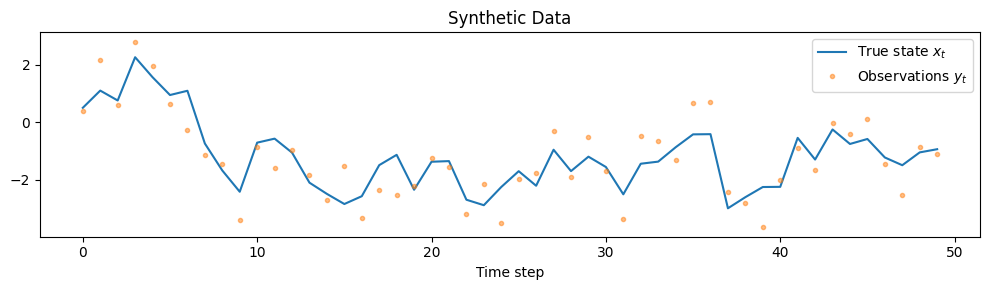

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

# Ground-truth parameters
T_steps   = 50
A_TRUE    = 0.9
Q_TRUE    = 1.0      # process noise variance
H_TRUE    = 1.0
R_TRUE    = 0.5      # observation noise variance

# Simulate
xs_true = np.zeros(T_steps)
ys_true = np.zeros(T_steps)
x = 0.0
for t in range(T_steps):
    x = A_TRUE * x + np.sqrt(Q_TRUE) * np.random.randn()
    y = H_TRUE * x + np.sqrt(R_TRUE) * np.random.randn()
    xs_true[t] = x
    ys_true[t] = y

observations = tf.constant(ys_true[:, None], dtype=tf.float32)  # [T, 1]

plt.figure(figsize=(10, 3))
plt.plot(xs_true, label='True state $x_t$')
plt.plot(ys_true, '.', alpha=0.5, label='Observations $y_t$')
plt.xlabel('Time step')
plt.legend()
plt.title('Synthetic Data')
plt.tight_layout()
plt.show()

## Cell 8 — Test 1: Gradient Verification (Soft Resampling)

We build a DPF with `SoftResampler(alpha=0.5)`, compute the negative log-evidence, and verify that `tf.GradientTape` returns non-`None` gradients for all model parameters.

In [8]:
# Build model with learnable parameters (initialised slightly off)
transition = LinearGaussianTransition(
    A=tf.constant([[0.8]]),
    Q_chol=tf.constant([[1.0]])
)
observation = LinearGaussianObservation(
    H=tf.constant([[1.0]]),
    R_chol=tf.constant([[np.sqrt(0.5)]], dtype=tf.float32)
)

soft_resampler = SoftResampler(alpha=0.5)
dpf_soft = DifferentiableParticleFilter(
    transition, observation, soft_resampler, ess_threshold=0.5
)

trainable_vars = [transition.A, transition.Q_chol,
                  observation.H, observation.R_chol]

with tf.GradientTape() as tape:
    _, _, log_evidence = dpf_soft.filter(
        observations, batch_size=4, n_particles=200
    )
    loss = -tf.reduce_mean(log_evidence)

grads = tape.gradient(loss, trainable_vars)

print("="*60)
print("TEST 1: Soft Resampling — Gradient Check")
print("="*60)
print(f"  Log-evidence (mean): {tf.reduce_mean(log_evidence).numpy():.4f}")
print(f"  Loss:                {loss.numpy():.4f}")
for var, g in zip(trainable_vars, grads):
    status = 'OK' if g is not None else '** NONE **'
    val = g.numpy() if g is not None else 'N/A'
    print(f"  grad({var.name:10s}) = {val}  [{status}]")

TEST 1: Soft Resampling — Gradient Check
  Log-evidence (mean): -81.9878
  Loss:                81.9878
  grad(A:0       ) = [[-6.2284784]]  [OK]
  grad(Q_chol:0  ) = [[2.3628955]]  [OK]
  grad(H:0       ) = [[3.692105]]  [OK]
  grad(R_chol:0  ) = [[1.9461387]]  [OK]


## Cell 9 — Test 2: Gradient Verification (OT / Sinkhorn Resampling)

Same test with `SinkhornResampler`. Note: OT resampling is $O(N^2)$ per step due to the cost matrix, so we use fewer particles.

In [9]:
# Reset parameters
transition.A.assign(tf.constant([[0.8]]))
transition.Q_chol.assign(tf.constant([[1.0]]))

ot_resampler = SinkhornResampler(epsilon=0.5, num_iters=30)
dpf_ot = DifferentiableParticleFilter(
    transition, observation, ot_resampler, ess_threshold=0.5
)

with tf.GradientTape() as tape:
    _, _, log_evidence_ot = dpf_ot.filter(
        observations, batch_size=4, n_particles=50
    )
    loss_ot = -tf.reduce_mean(log_evidence_ot)

grads_ot = tape.gradient(loss_ot, trainable_vars)

print("="*60)
print("TEST 2: Sinkhorn OT Resampling — Gradient Check")
print("="*60)
print(f"  Log-evidence (mean): {tf.reduce_mean(log_evidence_ot).numpy():.4f}")
print(f"  Loss:                {loss_ot.numpy():.4f}")
for var, g in zip(trainable_vars, grads_ot):
    status = 'OK' if g is not None else '** NONE **'
    val = g.numpy() if g is not None else 'N/A'
    print(f"  grad({var.name:10s}) = {val}  [{status}]")

TEST 2: Sinkhorn OT Resampling — Gradient Check
  Log-evidence (mean): -81.7977
  Loss:                81.7977
  grad(A:0       ) = [[-5.4977236]]  [OK]
  grad(Q_chol:0  ) = [[3.2417035]]  [OK]
  grad(H:0       ) = [[2.643318]]  [OK]
  grad(R_chol:0  ) = [[2.3137646]]  [OK]


## Cell 10 — Test 3: Learn Transition Parameter $A$ by Gradient Descent

We initialise $A = 0.5$ (far from the true value 0.9) and optimise the negative log-evidence using Adam. This demonstrates end-to-end learning through the differentiable PF.

In [10]:
# Reset to bad initial
transition.A.assign(tf.constant([[0.5]]))
transition.Q_chol.assign(tf.constant([[1.0]]))
observation.H.assign(tf.constant([[1.0]]))
observation.R_chol.assign(tf.constant([[np.sqrt(0.5)]],dtype=tf.float32))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

dpf_train = DifferentiableParticleFilter(
    transition, observation,
    SoftResampler(alpha=0.5),
    ess_threshold=0.5
)

# Only train A for this demo
train_vars = [transition.A]

losses = []
a_values = [transition.A.numpy().item()]

N_STEPS = 80
print(f"{'Step':>5} {'Loss':>10} {'A_learned':>10} {'A_true':>8}")
print("-" * 40)

for step in range(N_STEPS):
    with tf.GradientTape() as tape:
        _, _, log_ev = dpf_train.filter(
            observations, batch_size=8, n_particles=100
        )
        loss_step = -tf.reduce_mean(log_ev)

    grads_step = tape.gradient(loss_step, train_vars)

    # Clip gradients for stability
    grads_step = [tf.clip_by_value(g, -5.0, 5.0) for g in grads_step]
    optimizer.apply_gradients(zip(grads_step, train_vars))

    losses.append(loss_step.numpy())
    a_values.append(transition.A.numpy().item())

    if (step + 1) % 10 == 0:
        print(f"{step+1:5d} {loss_step.numpy():10.2f} "
              f"{transition.A.numpy().item():10.4f} {A_TRUE:8.1f}")

print(f"\nFinal A = {transition.A.numpy().item():.4f}  (true = {A_TRUE})")

 Step       Loss  A_learned   A_true
----------------------------------------
   10      87.08     0.6000      0.9
   20      84.59     0.7000      0.9
   30      82.07     0.8000      0.9
   40      82.01     0.8786      0.9
   50      82.28     0.8692      0.9
   60      81.86     0.8425      0.9
   70      81.69     0.8446      0.9
   80      82.16     0.8648      0.9

Final A = 0.8648  (true = 0.9)


In [11]:
# Reset to bad initial
transition.A.assign(tf.constant([[0.5]]))
transition.Q_chol.assign(tf.constant([[1.0]]))
observation.H.assign(tf.constant([[1.0]]))
observation.R_chol.assign(tf.constant([[np.sqrt(0.5)]],dtype=tf.float32))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

dpf_train = DifferentiableParticleFilter(
    transition, observation,
    SinkhornResampler(epsilon=0.2, num_iters=40),
    ess_threshold=0.5
)

# Only train A for this demo
train_vars = [transition.A]

losses_2 = []
a_values_2 = [transition.A.numpy().item()]

N_STEPS = 80
print(f"{'Step':>5} {'Loss':>10} {'A_learned':>10} {'A_true':>8}")
print("-" * 40)

for step in range(N_STEPS):
    with tf.GradientTape() as tape:
        _, _, log_ev = dpf_train.filter(
            observations, batch_size=8, n_particles=100
        )
        loss_step = -tf.reduce_mean(log_ev)

    grads_step = tape.gradient(loss_step, train_vars)

    # Clip gradients for stability
    grads_step = [tf.clip_by_value(g, -5.0, 5.0) for g in grads_step]
    optimizer.apply_gradients(zip(grads_step, train_vars))

    losses_2.append(loss_step.numpy())
    a_values_2.append(transition.A.numpy().item())

    if (step + 1) % 10 == 0:
        print(f"{step+1:5d} {loss_step.numpy():10.2f} "
              f"{transition.A.numpy().item():10.4f} {A_TRUE:8.1f}")

print(f"\nFinal A = {transition.A.numpy().item():.4f}  (true = {A_TRUE})")

 Step       Loss  A_learned   A_true
----------------------------------------
   10      86.75     0.6000      0.9
   20      83.77     0.7000      0.9
   30      81.97     0.8000      0.9
   40      81.51     0.8840      0.9
   50      81.51     0.8818      0.9
   60      81.60     0.8524      0.9
   70      80.73     0.8608      0.9
   80      81.45     0.8719      0.9

Final A = 0.8719  (true = 0.9)


## Cell 11 — Visualise Results

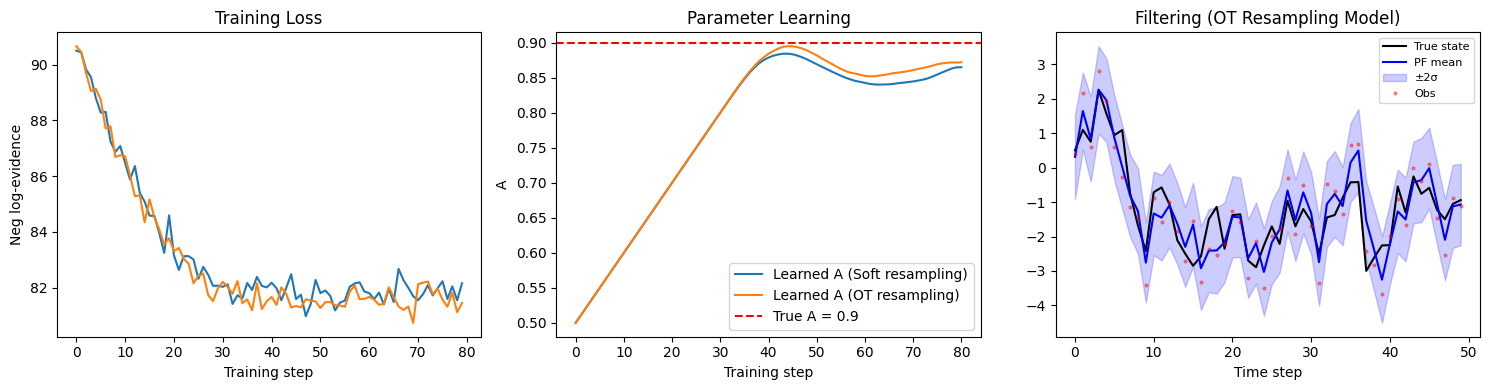

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# --- Training loss ---
axes[0].plot(losses,label='Soft resampling')
axes[0].plot(losses_2,label='OT resampling')
axes[0].set_xlabel('Training step')
axes[0].set_ylabel('Neg log-evidence')
axes[0].set_title('Training Loss')

# --- Learned A ---
axes[1].plot(a_values,label='Learned A (Soft resampling)')
axes[1].plot(a_values_2,label='Learned A (OT resampling)')
axes[1].axhline(A_TRUE, color='r', linestyle='--', label=f'True A = {A_TRUE}')
axes[1].set_xlabel('Training step')
axes[1].set_ylabel('A')
axes[1].set_title('Parameter Learning')
axes[1].legend()

# --- Filtering with final model ---
dpf_eval = DifferentiableParticleFilter(
    transition, observation,
    SinkhornResampler(epsilon=0.2, num_iters=40),
    ess_threshold=0.5
)
all_p, all_lw, _ = dpf_eval.filter(
    observations, batch_size=1, n_particles=500
)

# Compute weighted mean per time step
means = []
stds = []
for t in range(T_steps):
    w = tf.exp(all_lw[t])          # [1, N]
    p = all_p[t]                   # [1, N, 1]
    m = tf.reduce_sum(w[:, :, None] * p, axis=1)  # [1, 1]
    v = tf.reduce_sum(w[:, :, None] * (p - m[:, None, :])**2, axis=1)
    means.append(m.numpy()[0, 0])
    stds.append(np.sqrt(v.numpy()[0, 0]))

means = np.array(means)
stds = np.array(stds)

axes[2].plot(xs_true, 'k-', label='True state', linewidth=1.5)
axes[2].plot(means, 'b-', label='PF mean', linewidth=1.5)
axes[2].fill_between(range(T_steps),
                     means - 2*stds, means + 2*stds,
                     alpha=0.2, color='b', label='±2σ')
axes[2].plot(ys_true, 'r.', alpha=0.4, markersize=4, label='Obs')
axes[2].set_xlabel('Time step')
axes[2].set_title('Filtering (OT Resampling Model)')
axes[2].legend(fontsize=8)

plt.tight_layout()
plt.show()